In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pyslabgrid import eqcatana as eqc

In [2]:
def get_mags(catalog, min_year=1900, min_mag=3.0, slabzone = 'hik-whole', decimate=None):
    cat_folder = '../02midslab-config/projected_catalogs/'
    eqcat = eqc.read_projectedslabcatalog(cat_folder+catalog, min_year=min_year, min_mag=min_mag)
    slon = np.array(eqcat['slon'])
    slat = np.array(eqcat['slat'])
    smag = np.array(eqcat['mag'])

    in_zone = eqc.get_inpolgyon((eqcat['slon'],eqcat['slat']), eqc.get_zonepolygon(slabzone))
    mags_in_zone = smag[in_zone]
    if decimate is not None:
        mags_in_zone = [round(m, decimate) for m in mags_in_zone]
    return mags_in_zone

def calc_bvalue(M, binsize=0.1, Mmin=None, echo=False):
    # calculate b-value using the MLE method
    if Mmin is None:
        Mmin  = min(M)
    else:
        M = [m for m in M if m>=Mmin]
    if echo:
        if len(M)<25:
            print('*** number of events (<25) is rather scant')
    Mmean = np.mean(M)
    bvalue = (1/(Mmean-(Mmin-(binsize/2.0))))*np.log10(np.exp(1)); 
    return bvalue

def boot_bvalues(slabzone, catalog, Mc=5.0, Mmins=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    catfile = catalog['file']
    cat_minyear = catalog['minyear']
    mags = get_mags(catfile, min_year=cat_minyear, \
                    slabzone = slabzone, decimate = 1)
    if Mmins is None:
        Mmins = [round(m,1) for m in np.arange(3.5, 5.2, 0.1)]
        
    bvalues = {}
    for m in Mmins:
        m = round(m,1)
        bvalues.update({m: []})
        
    for i in range(1000):
        bees = []
        for mmin in Mmins:
            mmin = round(mmin,1)
            M = [m for m in mags if m>=mmin]
            bootmag = np.random.choice(M, size=len(M), replace=True, p=None)
            b = round(calc_bvalue(bootmag.tolist()),2)
            bees.append(b)
            bvalues[mmin].append(b)
        ax.plot(Mmins, bees, '-', linewidth = 0.5, color='#ADD8E6')
    
    bval = []
    bvalstd = []
    for m in Mmins:
        bval.append(round(calc_bvalue(mags, Mmin=m),2))
        bvalstd.append(np.std(bvalues[m]))
        
    ax.errorbar(Mmins, bval, xerr = None, yerr = bvalstd, \
                capsize=4, linewidth=1, color='r', zorder=10)
    ax.plot(Mmins, bval, 'o', color='k', zorder=20)
    
    yyy = [y for y in np.arange(0,2,0.1)]
    xxx = [Mc]*len(yyy)
    ax.plot(xxx, yyy, 'k--', linewidth=0.5)
    
    ax.set_ylim([0.3, 1.8])
    min_Mmins = min(Mmins)
    ax.set_xlim([min_Mmins-0.02, max(Mmins)+0.02])
    
    bvalue =  calc_bvalue(mags, Mmin=Mc) #np.mean(bvalues[Mc]) #
    bvalue_std = np.std(bvalues[Mc])
    
    zonename ={
        'hik-whole': 'Hikurangi-whole',
        'hik-flat': 'Hikurangi-shallow',
        'hik-steep': 'Hikurangi-deep',
        'puy-whole': 'Puysegur-whole',
        'puy-flat': 'Puysegur-shallow',
        'puy-steep': 'Puysegur-deep',
    }
    ax.text(min_Mmins+0.07, 1.65, '%s (%s-2020)'%(zonename[slabzone],cat_minyear))
    ax.text(min_Mmins+0.07, 1.5, 'N(M$_C$) = %d, M$_C$=%.1f' %(len([m for m in mags if m>=Mc]), Mc))
    ax.text(min_Mmins+0.07, 0.4, 'b-value=%.2f($\pm$%.2f)' %(bvalue, bvalue_std))
    return bvalue, bvalue_std

def get_magbins(M, binsiz=0.1):
    set_mag = [round(m,1) for m in np.arange(min(M), max(M)+binsiz, binsiz)]
    M = np.array(M)
    cumkount, kount, mag = [],[],[]
    for m in set_mag:
        k = sum(M==m)
        cumk = sum(M>=m)
        if k>0:
            kount.append(k)  
            cumkount.append(cumk)
            mag.append(m)
    return mag, kount, cumkount

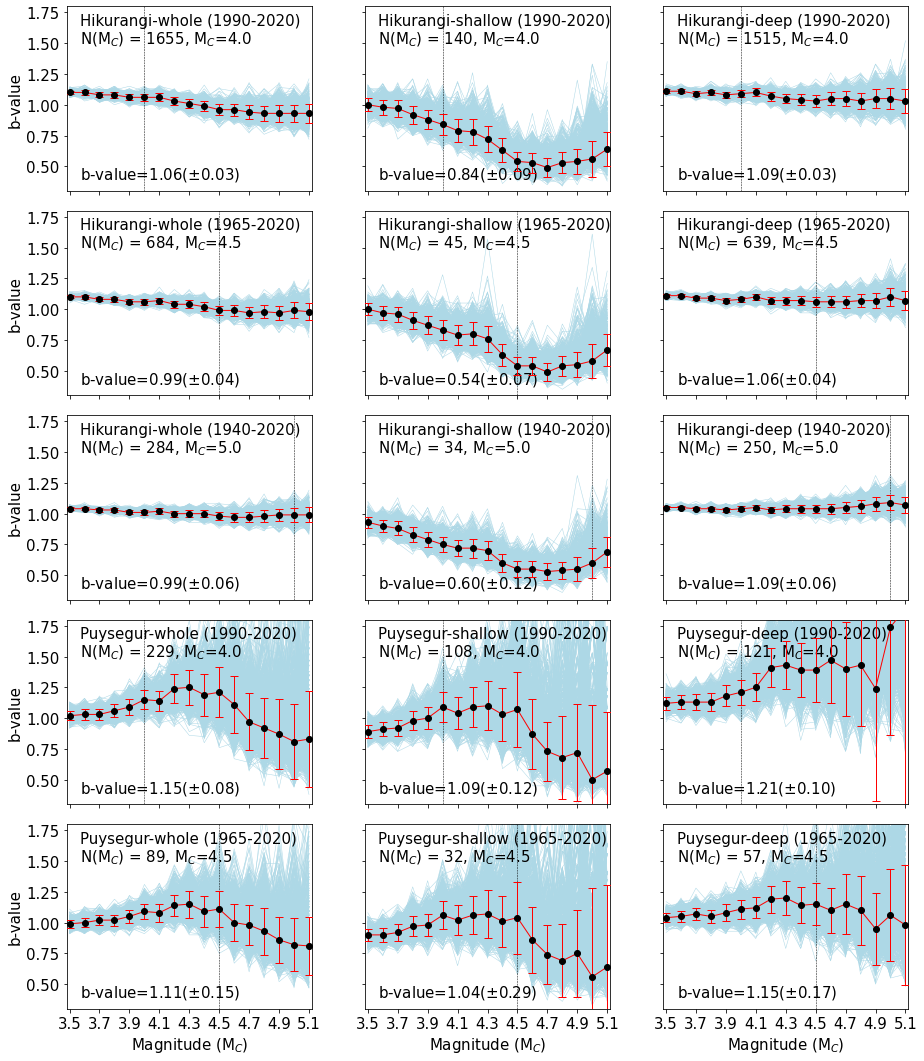

In [3]:
# catalogues
original_catalog = 'NZeqcat_Rollins13042020-subd-slab-proj2midslab.csv'
declustered_catalog = 'Grue_NZeqcat_Rollins13042020SEPI-subd-slab-proj2midslab.csv'
grparams = {}
#minyear_hik = 1990
#minyear_puy = 1965
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(5,3, figsize=(13,15), sharex=True, sharey=True)

catalog = {'file': original_catalog, 'minyear': 1990}
bvalue, bvalue_std = boot_bvalues('hik-whole', catalog, Mc=4.0, Mmins=None, ax =ax[0,0])
grparams.update({'hik-whole': [bvalue, bvalue_std]})

bvalue, bvalue_std = boot_bvalues('hik-flat', catalog, Mc=4.0, Mmins=None, ax =ax[0,1])
grparams.update({'hik-flat': [bvalue, bvalue_std]})

bvalue, bvalue_std = boot_bvalues('hik-steep', catalog, Mc=4.0, Mmins=None, ax =ax[0,2])
grparams.update({'hik-steep':[bvalue, bvalue_std]})

catalog = {'file': original_catalog, 'minyear': 1965}
boot_bvalues('hik-whole', catalog, Mc=4.5, Mmins=None, ax =ax[1,0])
boot_bvalues('hik-flat', catalog, Mc=4.5, Mmins=None, ax =ax[1,1])
boot_bvalues('hik-steep', catalog, Mc=4.5, Mmins=None, ax =ax[1,2])

catalog = {'file': original_catalog, 'minyear': 1940}
boot_bvalues('hik-whole', catalog, Mc=5.0, Mmins=None, ax =ax[2,0])
boot_bvalues('hik-flat', catalog, Mc=5.0, Mmins=None, ax =ax[2,1])
boot_bvalues('hik-steep', catalog, Mc=5.0, Mmins=None, ax =ax[2,2])

catalog = {'file': original_catalog, 'minyear': 1990}
bvalue, bvalue_std = boot_bvalues('puy-whole', catalog, Mc=4.0, Mmins=None, ax =ax[3,0])
grparams.update({'puy-whole': [bvalue, bvalue_std]})

bvalue, bvalue_std = boot_bvalues('puy-flat', catalog, Mc=4.0, Mmins=None, ax =ax[3,1])
grparams.update({'puy-flat': [bvalue, bvalue_std]})

bvalue, bvalue_std = boot_bvalues('puy-steep', catalog, Mc=4.0, Mmins=None, ax =ax[3,2])
grparams.update({'puy-steep': [bvalue, bvalue_std]})

catalog = {'file': original_catalog, 'minyear': 1965}
boot_bvalues('puy-whole', catalog, Mc=4.5, Mmins=None, ax =ax[4,0])
boot_bvalues('puy-flat', catalog, Mc=4.5, Mmins=None, ax =ax[4,1])
boot_bvalues('puy-steep', catalog, Mc=4.5, Mmins=None, ax =ax[4,2])

xx = [x for x in np.arange(3.5,5.2,0.2)]
ax[4,0].set_xticks(xx)

ax[4,0].set_xlabel('Magnitude (M$_C$)')
ax[4,1].set_xlabel('Magnitude (M$_C$)')
ax[4,2].set_xlabel('Magnitude (M$_C$)')

ax[0,0].set_ylabel('b-value')
ax[1,0].set_ylabel('b-value')
ax[2,0].set_ylabel('b-value')
ax[3,0].set_ylabel('b-value')
ax[4,0].set_ylabel('b-value')

plt.tight_layout()
plt.savefig('Figure5.jpeg', dpi=300, facecolor='w');